This notebook contains the analyses associated with partition initialization:
- A comparison of accuracy of final bin count vs. processing samples all at once
- A comparison of accuracy of Sobol' indices vs processing samples all at once

In [1]:
import scipy.stats as ss
import numpy as np
from matplotlib import rcParams
rcParams['text.usetex'] = True
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Times']
import matplotlib.pyplot as plt

# Custom formatter to show scientific notation without offset
from matplotlib.ticker import FuncFormatter
def sci_formatter(x, significant_digits=1):
    s = f'{x:.{significant_digits}e}'
    s = s.replace('e+0', 'e').replace('e-0','e-').replace('e0','')
    return s
import streaming_data_gsa as sdg
#import empirical_sobol as es
import os
from test_functions import polynomialSobols, Ishigami
#from convergence_analysis_methods import *

if not os.path.exists('figs'): os.mkdir('figs')

In [2]:
urv = ss.uniform()
nrv = ss.norm()
erv = ss.expon()

In [3]:
upoly = polynomialSobols(1,1,10, 'uniform')
npoly = polynomialSobols(1,1,1,'normal')
epoly = polynomialSobols(1,1,10,'exponential')
ishigami = Ishigami( 7, 0.1 )

# Bin initialization

### Bin count investigation

In [4]:
figdir = 'figs/bin_count_results/'
if not os.path.exists(figdir): os.makedirs(figdir)

Here we study how final bin count accuracy is impacted by the partitioning method and how many samples per bin are used in the initialization.

In [5]:
def get_equiprobable_bin_counts(rv, nb=100, nreps=100, n_est_multiplier=[2,100],seed=20250507):
    ne = len(n_est_multiplier)
    bin_cts_kde = np.zeros((ne, nreps, nb))
    bin_cts_quantile = np.zeros((ne, nreps, nb))

    for j, nem in enumerate(n_est_multiplier):
        n_est = nem * nb
        np.random.seed(seed)
        for k in range(nreps):
            x = rv.rvs((nb*1000,1))
            m_kde = sdg.StreamingDataGSABatched(1, 1 , nb, n_est, binning_method='kde', bin_to_inf=True)
            m_kde.process_samples(x,x)
            bin_cts_kde[j,k] = m_kde.bin_counts[0]

            m_quantile = sdg.StreamingDataGSABatched(1, 1 , nb, n_est, binning_method='quantile', bin_to_inf=True)
            m_quantile.process_samples(x,x)
            bin_cts_quantile[j,k] = m_quantile.bin_counts[0]

    return bin_cts_kde, bin_cts_quantile

u_bin_cts_kde, u_bin_cts_quantile = get_equiprobable_bin_counts(urv, nreps=100)
n_bin_cts_kde, n_bin_cts_quantile = get_equiprobable_bin_counts(nrv, nreps=100)
e_bin_cts_kde, e_bin_cts_quantile = get_equiprobable_bin_counts(erv, nreps=100)

In [6]:
def get_equidistant_bin_counts(rv, nb=100, nreps=100, n_est_multiplier=[2,100],seed=20250507):
    ne = len(n_est_multiplier)
    bin_cts_dx = np.zeros((ne, nreps, nb))

    for j, nem in enumerate(n_est_multiplier):
        n_est = nem * nb
        np.random.seed(seed)
        for k in range(nreps):
            x = rv.rvs((nb*1000,1))
            m_dx = sdg.StreamingDataGSABatched(1, 1 , nb, n_est, binning_method='dx', bin_to_inf=True)
            m_dx.process_samples(x,x)
            bin_cts_dx[j,k] = m_dx.bin_counts[0]

    return bin_cts_dx

u_bin_cts_dx = get_equidistant_bin_counts(urv, nreps=100)
n_bin_cts_dx = get_equidistant_bin_counts(nrv, nreps=100)
e_bin_cts_dx = get_equidistant_bin_counts(erv, nreps=100)

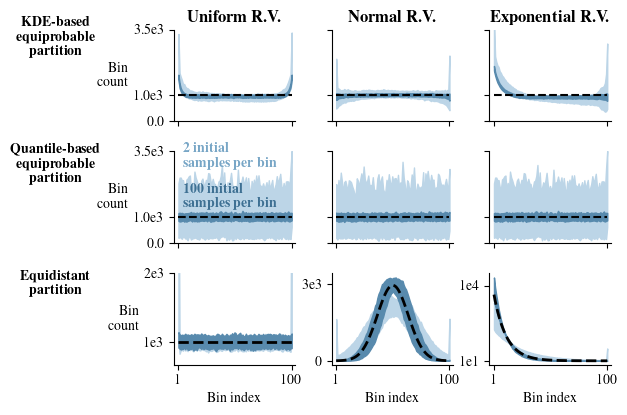

In [7]:
def get_quantiles(bin_cts):
    return np.quantile(bin_cts, q=[.05,0.95], axis=1)

fig = plt.figure(figsize=(5.5,4.25))
axs = fig.subplots(3,3,sharex=True)

inds = 1+np.arange(u_bin_cts_kde.shape[-1])
for i, (bin_cts_kde, bin_cts_quantile) in enumerate(zip(
    [u_bin_cts_kde,n_bin_cts_kde,e_bin_cts_kde], 
    [u_bin_cts_quantile,n_bin_cts_quantile,e_bin_cts_quantile])):
    axi = axs.T[i]

    qs_kde = get_quantiles(bin_cts_kde)
    axi[0].fill_between(inds, qs_kde[0][0], qs_kde[1][0], color='#bcd5e7')
    axi[0].fill_between(inds, qs_kde[0][1], qs_kde[1][1], color="#588aad")
    
    qs_quantile = get_quantiles(bin_cts_quantile)
    axi[1].fill_between(inds, qs_quantile[0][0], qs_quantile[1][0], color='#bcd5e7')
    axi[1].fill_between(inds, qs_quantile[0][1], qs_quantile[1][1], color="#588aad")

for i, ax in enumerate(axs.T[0]):
    ax.set_ylabel('Bin\ncount', rotation=0, ha='right', va='center')

for i, ax in enumerate(axs[:2].flatten()):
    ax.set_yticks([0,1000,3500])
    ax.set_yticklabels([sci_formatter(yt,1) for yt in ax.get_yticks()])
    ax.hlines(1000, inds.min(),inds.max(), 'k', linestyles='dashed')
    ax.set_ylim([0,3500])
for ax in axs[:2,1:].flatten(): ax.set_yticklabels([])

for ax, title in zip(axs[0], ['Uniform R.V.', 'Normal R.V.', 'Exponential R.V.']):
    ax.set_title(rf'\textbf{{{title}}}')

for ax in axs[-1]:
    ax.set_xticks([1,100])
    ax.set_xlabel('Bin index')
    ax.set_xlim([-3,103])

for ax, bin_cts, rv in zip(axs[2], [u_bin_cts_dx,n_bin_cts_dx,e_bin_cts_dx], [urv, nrv, erv]):
    qs_dx = get_quantiles(bin_cts)
    ax.fill_between(inds, qs_dx[0][0], qs_dx[1][0], color='#bcd5e7')
    ax.fill_between(inds, qs_dx[0][1], qs_dx[1][1], color="#588aad")

    # Plotting the anticipated samples per bin with analytical sampling
    nb = bin_cts.shape[-1]
    ntot = nb*1000
    prob_bdy = 1e-4
    lb = rv.ppf(0) if not rv.ppf(0)==-np.inf else rv.ppf(prob_bdy)
    ub = rv.ppf(1) if not rv.ppf(1)==np.inf else rv.ppf(1-prob_bdy)
    support = np.linspace(lb,ub,bin_cts.shape[-1]+1)
    cdfs = rv.cdf(support)
    probs = cdfs[1:] - cdfs[:-1]
    ax.plot(inds,probs*ntot, 'k--', lw=2)

axs[2][0].set_ylim(axs[2][0].get_ylim()[0], 1500)
axs[2][1].set_yticks([0,3000])
axs[2][0].set_yticks([1000,1500])
axs[2][-1].set_yticks([10,1e4])
for ax in axs[2]:
    ax.set_yticklabels([sci_formatter(yt,0) for yt in ax.get_yticks()])

for ax in axs.flatten():
    ax.spines[['top','right']].set_visible(False)

ax = axs[1][0]
ax.annotate(r'\textbf{2 initial}'+'\n'+r'\textbf{samples per bin}', (5, 2800), ha='left', va='bottom', color="#78a6c6")
ax.annotate(r'\textbf{100 initial}'+'\n'+r'\textbf{samples per bin}', (5, 1250), ha='left', va='bottom', color="#3e7093")

def bold_wrap(strlist):
    return '\n'.join([rf'\textbf{{{s}}}' for s in strlist])
fig.text(-0.05, .9, bold_wrap(['KDE-based','equiprobable','partition']), ha='center', va='center')
fig.text(-0.05, 0.6, bold_wrap(['Quantile-based','equiprobable','partition']), ha='center', va='center')
fig.text(-0.05, 0.32, bold_wrap(['Equidistant','partition']), ha='center', va='center')

fig.tight_layout(w_pad=0)
fig.savefig(f'{figdir}/bin_count_comparison.pdf', bbox_inches='tight')

### Convergence studies on Sobol' indices as a function of binning method

Here we study the accuracy of our streaming algorithm, which employs prespecified bins using a small initial sample size, vs.~the all-at-once approach which uses all samples for binning.

In [8]:
figdir='figs/streaming_vs_aao_convergence/'
if not os.path.exists(figdir): os.makedirs(figdir)

The numbers over the violin plots indicate the number of initial samples per bin. We always use 100 * the number of bins for total sample size. True Sobol' index values are indicated in black.

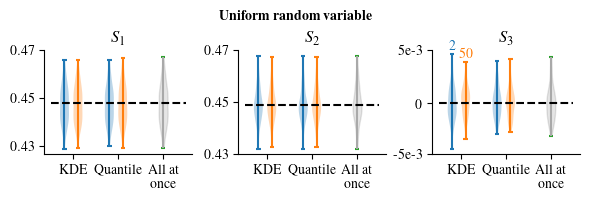

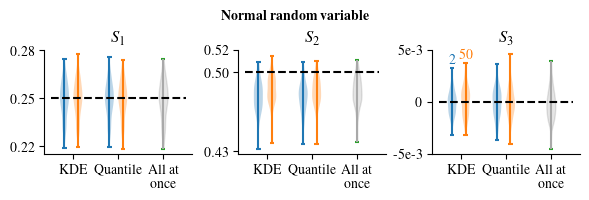

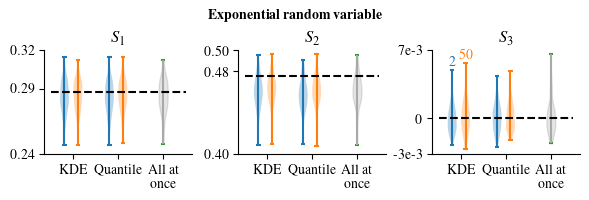

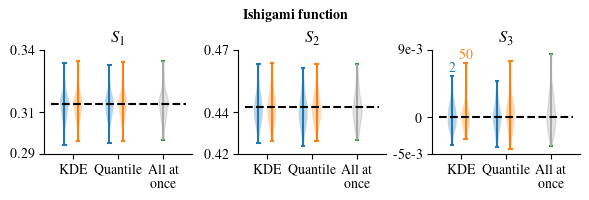

In [9]:
def equiprob_sobols_vs_aao(model, nbins=100, n_est_multiplier=[2,50], nreps=100, seed=20250321):

    n_tot = 100*nbins
    n_ests = len(n_est_multiplier)
    Strue = model.main_effects

    nrows, ncols = 1, Strue.size
    fig = plt.figure(figsize=(6,2*nrows))
    axs = fig.subplots(nrows, ncols, sharex=True, sharey='col')

    sobols_kde = np.zeros((n_ests, nreps, 3))
    sobols_quantile = np.zeros((n_ests, nreps, 3))
    sobols_aao = np.zeros((nreps, 3))
    for j, nem in enumerate(n_est_multiplier):
        n_est = nem * nbins
        np.random.seed(seed)
        for k in range(nreps):
            x = model.generate_samples(n_tot)
            y = model.evaluate(x)

            m_kde = sdg.StreamingDataGSABatched(3, 1, nbins, n_est, binning_method='kde', bin_to_inf=True)
            m_kde.process_samples(x,y)
            sobols_kde[j,k] = m_kde.get_sobol_indices()
            
            m_quantile = sdg.StreamingDataGSABatched(3, 1, nbins, n_est, binning_method='quantile', bin_to_inf=True)
            m_quantile.process_samples(x,y)
            sobols_quantile[j,k] = m_quantile.get_sobol_indices()

            if j==0:
                m_aao = sdg.StreamingDataGSABatched(3, 1, nbins, n_tot, binning_method='quantile', bin_to_inf=True)
                m_aao.process_samples(x,y)
                sobols_aao[k] = m_aao.get_sobol_indices()

    si = 1+np.arange(3)
    for i in range(ncols):
        for j, ne in enumerate(n_est_multiplier):
            sobols_compare = np.array([sobols_kde[j,:,i], sobols_quantile[j,:,i]]).T
            axs[i].violinplot(sobols_compare, positions=0.8+j*0.3+np.arange(2), widths=0.2)
            if i==2:
                axs[i].annotate(f'{ne}', (0.8+j*0.3, sobols_compare[:,0].max()*1.05),ha='center',va='bottom', color=f'C{j}')
        aao = axs[i].violinplot(sobols_aao[:,i],positions=np.array([3]), widths=0.20)
        aao['bodies'][0].set_facecolor('black')
        aao['bodies'][0].set_edgecolor('black')
        aao['bodies'][0].set_alpha(0.1)
        aao['cbars'].set_color('darkgrey')

        axs[i].hlines(Strue[i],0.5,3.5,'k',ls='--')

        if i<2:
            axs[i].set_yticks(np.round([axs[i].get_ylim()[0], axs[i].get_ylim()[1], Strue[i]],2))
        else:
            axs[i].set_yticks([axs[i].get_ylim()[0], Strue[i], axs[i].get_ylim()[1]])
            axs[i].set_yticklabels([sci_formatter(axs[i].get_ylim()[0],0),
                                    sci_formatter(Strue[i],0),
                                    sci_formatter(axs[i].get_ylim()[1],0)])

        axs[i].set_xticks(np.arange(1,4))
        axs[i].set_xticklabels(['KDE','Quantile','All at\nonce'], ha='center')
        axs[i].spines[['top','right']].set_visible(False)
        axs[i].set_title(f'$S_{i+1}$')

    fig.tight_layout(rect=[0,0,1,0.95], w_pad=0.5)
    if model.name=='Ishigami':
        fig.suptitle( r'\textbf{Ishigami function}', fontsize=10, x=0.5, ha='center')
        fig.savefig(f'{figdir}/equiprob_compare_ishigami.pdf', bbox_inches='tight')
    else:
        title_str = r'\textbf{'+f'{model.dist_type.capitalize()} random variable'+r'}'
        fig.suptitle( title_str, fontsize=10, x=0.5, ha='center')
        fig.savefig(f'{figdir}/equiprob_compare_{model.dist_type}.pdf', bbox_inches='tight')


nreps=100
equiprob_sobols_vs_aao(upoly, nreps=nreps)
equiprob_sobols_vs_aao(npoly,nreps=nreps)
equiprob_sobols_vs_aao(epoly,nreps=nreps)
equiprob_sobols_vs_aao(ishigami,nreps=nreps)

Here we compare accuracy for the equidistant binning approach.

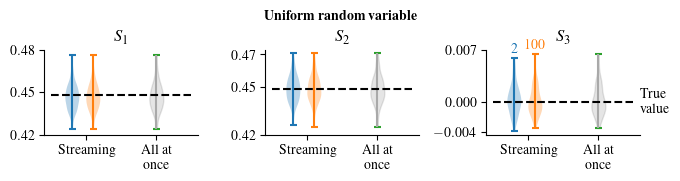

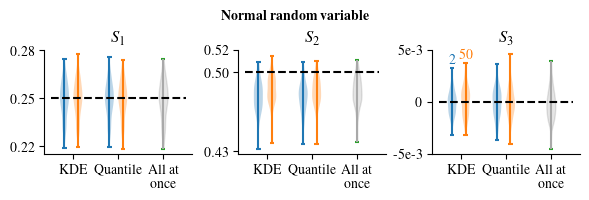

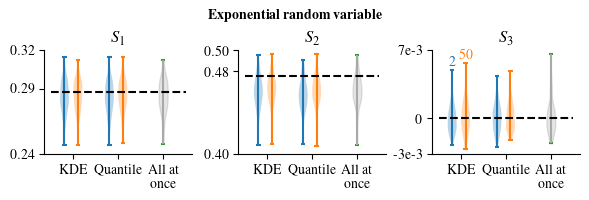

In [10]:
def equidist_sobols_vs_aao(model, nbins=100, n_est_multiplier=[2,100], nreps=100, seed=20250321):

    n_tot = 100*nbins
    n_ests = len(n_est_multiplier)
    Strue = model.main_effects

    nrows, ncols = 1, Strue.size
    fig = plt.figure(figsize=(2.3*ncols, 1.8*nrows))
    axs = fig.subplots(nrows, ncols, sharex=True, sharey='col')

    sobols_dx = np.zeros((n_ests, nreps, 3))
    sobols_aao = np.zeros((nreps, 3))
    for j, nem in enumerate(n_est_multiplier):
        n_est = nem * nbins
        np.random.seed(seed)
        for k in range(nreps):
            x = model.generate_samples(n_tot)
            y = model.evaluate(x)

            m_dx = sdg.StreamingDataGSABatched(3, 1, nbins, n_est, binning_method='dx', bin_to_inf=True)
            m_dx.process_samples(x,y)
            sobols_dx[j,k] = m_dx.get_sobol_indices()

            if j==0:
                m_aao = sdg.StreamingDataGSABatched(3, 1, nbins, n_tot, binning_method='dx', bin_to_inf=True)
                m_aao.process_samples(x,y)
                sobols_aao[k] = m_aao.get_sobol_indices()

    si = 1+np.arange(3)
    for i in range(ncols):
        for j, ne in enumerate(n_est_multiplier):
            axs[i].violinplot(sobols_dx[j,:,i], positions=np.atleast_1d(0.8+j*0.3+np.arange(1)), widths=0.2)
            if i==2:
                axs[i].annotate(f'{ne}', (0.8+j*0.3, sobols_dx[j,:,i].max()*1.05), va='bottom', ha='center', color=f'C{j}')
        aao = axs[i].violinplot(sobols_aao[:,i],positions=np.array([2]), widths=0.20)
        aao['bodies'][0].set_facecolor('black')
        aao['bodies'][0].set_edgecolor('black')
        aao['bodies'][0].set_alpha(0.1)
        aao['cbars'].set_color('darkgrey')

        axs[i].hlines(Strue[i],0.5,2.5,'k',ls='--')

        if i<2:
            axs[i].set_yticks(np.round([axs[i].get_ylim()[0], axs[i].get_ylim()[1], Strue[i]],2))
        else:
            axs[i].set_yticks(np.round([axs[i].get_ylim()[0], axs[i].get_ylim()[1], Strue[i]],3))

        axs[i].set_xticks(np.arange(1,3))
        axs[i].set_xticklabels(['Streaming','All at\nonce'], ha='center')
        axs[i].spines[['top','right']].set_visible(False)
        axs[i].set_title(f'$S_{i+1}$')
    
    axs[-1].annotate('True\nvalue', (2.6,0), va='center')

    fig.tight_layout(rect=[0,0,1,0.95])
    if model.name=='Ishigami':
        fig.suptitle( r'\textbf{Ishigami function}', fontsize=10, x=0.5, ha='center')
        #fig.savefig(f'{figdir}/equiprob_compare_ishigami.png', dpi=300, transparent=True, bbox_inches='tight')
        fig.savefig(f'{figdir}/equiprob_compare_ishigami.pdf', bbox_inches='tight')
    else:
        title_str = r'\textbf{'+f'{model.dist_type.capitalize()} random variable'+r'}'
        fig.suptitle( title_str, fontsize=10, x=0.5, ha='center')
        #fig.savefig(f'{figdir}/equiprob_compare_{model.dist_type}.png', dpi=300, transparent=True, bbox_inches='tight')
        fig.savefig(f'{figdir}/equiprob_compare_{model.dist_type}.pdf', bbox_inches='tight')

nreps=100
equidist_sobols_vs_aao(upoly, nbins=50, nreps=nreps)
equiprob_sobols_vs_aao(npoly,nreps=nreps)
equiprob_sobols_vs_aao(epoly,nreps=nreps)

Overall the accuracy seems robust to the initial binning approach.